# Solving Geoguessr with Multimodal Language Models Using RAG

Geoguessr is a popular game where one must guess the location of the presented Google Street View image

![image](https://images.squarespace-cdn.com/content/v1/60f6054f4e76b03092956de8/fbba3851-0172-409c-9eb0-2cbefadce395/Geoguessr+HUD.png)
(Example from https://www.plonkit.net/beginners-guide)

This notebook contains an implementation of RAG for solving these problems with multimodal LLMs, and compares the performance of 3 models: OpenAI's GPT-4o, Google's Gemini-1.5, and Anthropic's Claude 3.5

## Setup for RAG

### Images

The images were downloaded from [https://www.kaggle.com/datasets/ubitquitin/geolocation-geoguessr-images-50k?resource=download](https://www.kaggle.com/datasets/ubitquitin/geolocation-geoguessr-images-50k?resource=download)

Here is an example:

![image](images/Australia/canvas_1629281323.jpg)

Then, we extract a random image using the function below:

In [1]:
import glob
import pycountry
import random

def get_random_image():
   """Return a dict of path image with its corresponding full country name
   args:
      None
   
   returns:
      dict with fields "country" and "image_path"
   """
   
   paths = glob.glob("./images/*/*.jpg")
   image_path = random.choice(paths)
   # ex. ./images/SLV/img_13.799272601660983,-89.23095180626325.jpg
   substr = image_path[9:]
   country_name = substr[:substr.find('/')]
   
   return {"country": country_name, "image_path": image_path}

### Reference Document

For RAG, we need to retrieve an "expert" document in order to improve the LLM's answer.
The document used is from [https://somerandomstuff1.wordpress.com/2019/02/08/geoguessr-the-top-tips-tricks-and-techniques/](https://somerandomstuff1.wordpress.com/2019/02/08/geoguessr-the-top-tips-tricks-and-techniques/)
It is stored in the file reference.txt

## RAG
The full implementation is stored in rag.py, but an example for OpenAI is shown here

To run locally, add a .env file containing API keys for OpenAI, Anthropic, and Google 

### LLM initialization

In [2]:
import base64
import json
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.document_loaders import TextLoader
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from IPython.display import Image
from tqdm import tqdm 

load_dotenv() # The API keys are stored in a .env file

True

In [3]:
llm = ChatOpenAI(model="gpt-4o", max_tokens=1024, temperature=0)

### Adding documents into a vector store

In [4]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = InMemoryVectorStore(embeddings) # There are other options for vector stores: https://python.langchain.com/docs/integrations/vectorstores/
document_ids = []

In [5]:
# Load the documents and split it into smaller chunks, 
# since the original document is too large

loader = TextLoader("reference.txt")
reference_doc = loader.load()
text_splitter = RecursiveCharacterTextSplitter(
   chunk_size=1000,  # chunk size (characters)
   chunk_overlap=200,  # chunk overlap (characters)
   add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(reference_doc)
document_ids = vector_store.add_documents(documents=all_splits)

### The RAG Workflow

The RAG logic is as follows:

1. Obtain an initial description of the image

2. Use that description to identify the relevant document chunks that can help with guessing the location

3. Finally, integrate the information to make an improved guess, including the reasoning

In [6]:
# 1. Obtain an initial description of the image
def describe(image_path):
      """An initial LLM description of a given image

      Args:
         image_path (str): path to image

      Returns:
         str: LLM description of image
      """
      with open(image_path, "rb") as image_file:
         image_data = base64.b64encode(image_file.read()).decode('utf-8')
      
      prompt = """
      Describe the image in detail, paying attention to details that can give clues about the location of this image. 
      Here are some example details:
      1. Car license plates
      2. Road marks and signals
      3. Left vs right driving
      4. Language
      5. Vegetation and weather/climate
      6. Geography, Flags
      7. House shape/materials
      ... and any other noteworthy details, no matter how small they are
      
      Finally, take a guess as to which country of the photo
      """

      msg = llm.invoke(
         [
               HumanMessage(
                  content=[
                     {"type": "text", "text": prompt},
                     {
                           "type": "image_url",
                           "image_url": {"url": f"data:image/png;base64,{image_data}"},
                     },
                  ]
               )
         ]
      )
      description = msg.content
      return description

In [7]:
# 2. Use that description to identify the relevant document chunks 
# that can help with guessing the location
def retrieve(location_clues):
   """Given a description of the location, find sections of the reference document
   that can help make a better guess

   Args:
      location_clues (str): Initial LLM description of picture

   Returns:
      str: Contents of relevent document chunks
   """
   retrieved_docs = vector_store.similarity_search(location_clues, k=3) # find relevant docs to the query
   docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
   return docs_content

In [8]:
# 3. Finally, integrate the information to make an improved guess, 
# including the reasoning
def generate(context, image_path):
   """Make an educated guess after consulting reference with RAG

   Args:
      context (str): Relevent document materials from vector store
      image_path (str): Path to image

   Returns:
      str: Output of the LLM
   """
   with open(image_path, "rb") as image_file:
      image_data = base64.b64encode(image_file.read()).decode('utf-8')
      
   prompt = f"""
      Carefully analyze the photo, in order to correctly guess the location of the photo.
      Give an elaborate reasoning as to why you chose the country. 
      You may include relevant details such as (don't include them if they are not relevant): 
      1. Car license plates
      2. Road marks and signals
      3. Left vs right driving
      4. Language
      5. Vegetation and weather
      6. Geography, Flags
      7. House shape/materials
      ... and any other noteworthy details, and corroborate with the following reference material,
      
      Some relevant materials: {context}
      
      Return your answer strictly in the following JSON format:
      {{
         "country" : "[country]",
         "reason" : "[reason]"
         
      }}
   """
   
   msg = llm.invoke(
      [
         HumanMessage(
            content=[
               {"type": "text", "text": prompt},
               {
                     "type": "image_url",
                     "image_url": {"url": f"data:image/png;base64,{image_data}"},
               },
            ]
         )
      ]
   )
   
   return msg.content

In [9]:
# Putting it all together:
def guess_location(image_path):
   """Use RAG to guess location of a Google Street View image

   Args:
      image_path (str): Path to image

   Returns:
      dict: dict containing the initial discription, the relevant docs, and the final response
   """

   initial_description = describe(image_path)
   reference = retrieve(initial_description)
   result = generate(reference, image_path)
   
   # extract guess from returned string, which should be in json form
   response = result.replace("`","")
   response = response.replace("json","")
   response = json.loads(response)

   
   return {"initial_description": initial_description, "reference": reference, "country": response["country"], "reason": response["reason"]}

Image from: South Korea


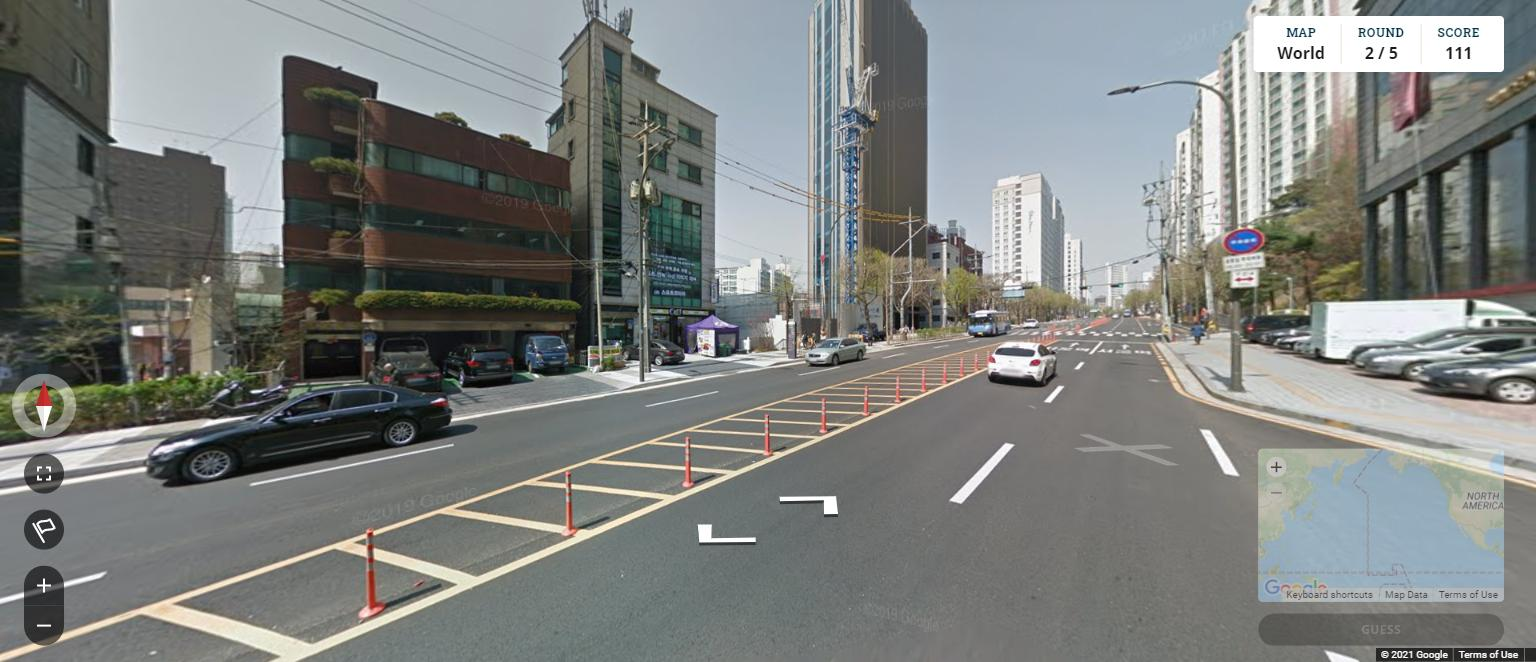

In [10]:
# An example run:
random_image = get_random_image()
print("Image from:", random_image["country"])
Image(filename=random_image["image_path"]) 

In [11]:
guess = guess_location(random_image["image_path"])

In [12]:
print("Initial Description:\n", guess["initial_description"])

Initial Description:
 The image shows an urban street scene with several details that can help identify the location:

1. **Car License Plates**: The license plates are not clearly visible, but the cars appear to be typical of those found in many urban areas.

2. **Road Marks and Signals**: The road has clear lane markings, and there are traffic cones separating lanes. The road signs are in a language that uses Hangul script, which is used in Korea.

3. **Left vs Right Driving**: The cars are driving on the right side of the road.

4. **Language**: The signs are in Korean, indicating that this is likely in South Korea.

5. **Vegetation and Weather/Climate**: The trees have leaves, suggesting a temperate climate. The weather appears clear and sunny.

6. **Geography, Flags**: There are no visible flags, but the urban setting with high-rise buildings is typical of a developed city.

7. **House Shape/Materials**: The buildings are modern, with a mix of glass and concrete, typical of urban 

In [13]:
print("Retrieved Documents:\n", guess["reference"])

Retrieved Documents:
 The urban parts of South Korea tend to be fairly busy. Cars drive on the right in South Korea which contrasts the country from Japan.
About 80% of the time when you pan down in South Korea, you will see the black Street View car.
About 20% of the time when you pan down in South Korea, you will see the white Street View car.
These blue signs provide road names in South Korea. They can be useful for helping you determine that you are indeed in South Korea and for helping pinpoint.
South Korean utility poles stand out as they mainly have what resembles a long, sharp, pointed spike extending upwards from the top of the main pole.
Bollards are fairly rare in South Korea, nonetheless, this is their front. Their rear has a yellow disk rather than a white disk.

South Korea’s Street View coverage was largely taken in the winter. As a result, seeing trees without leaves, snow and fairly bleak scenery is common throughout the country.
Although the winter coverage seems to b

In [14]:
print("Final Output:\n", guess["country"]+"\n", guess["reason"])

Final Output:
 South Korea
 The photo shows cars driving on the right side of the road, which is consistent with South Korea. The road signs feature Korean characters, which are distinctive with large circles, confirming the location. The urban environment with high-rise buildings and the style of utility poles with yellow and black diagonal stripes further support this. Additionally, the presence of a black Street View car is common in South Korea.


## Comparison
Here is a comparison of all of the models:

In [21]:
from rag import LLM_Guesser
from utils import get_random_image
num_trials = 50

In [22]:
locations = []
image_paths = []
for _ in range(num_trials):
   image = get_random_image()
   locations.append(image["country"])
   image_paths.append(image["image_path"])

print("Locations:", locations)

Locations: ['Brazil', 'Brazil', 'United States', 'United States', 'Argentina', 'Taiwan', 'Japan', 'United Kingdom', 'Poland', 'Japan', 'United States', 'Mexico', 'North Macedonia', 'United States', 'Guatemala', 'Malaysia', 'Germany', 'Switzerland', 'Mexico', 'Indonesia', 'New Zealand', 'New Zealand', 'Romania', 'Finland', 'United States', 'United States', 'United States', 'South Africa', 'Russia', 'Japan', 'Greece', 'United States', 'Russia', 'United States', 'United States', 'Japan', 'Malta', 'Finland', 'Japan', 'United States', 'Brazil', 'United States', 'Canada', 'Japan', 'South Africa', 'United States', 'Australia', 'Thailand', 'Australia', 'Bolivia']


In [23]:
openai_score = 0
for i in tqdm(range(num_trials)):
   llm = LLM_Guesser("GPT")
   guess = llm.guess_location(image_paths[i])["country"]
   if guess.upper() == locations[i].upper(): openai_score += 1
openai_score /= num_trials
print("Score for GPT-4o:", openai_score)

100%|██████████| 50/50 [14:58<00:00, 17.97s/it]

Score for GPT-4o: 0.74


In [ ]:
anthropic_score = 0

In [ ]:
# There may be some "overload" issues with Anthropic servers
# This section was done in 10 round increments to avoid this issue
for i in tqdm(range(40,50)):
   llm = LLM_Guesser("Claude")
   guess = llm.guess_location(image_paths[i])["country"]
   if guess.upper() == locations[i].upper(): anthropic_score += 1


100%|██████████| 10/10 [03:55<00:00, 23.57s/it]


In [ ]:
#anthropic_score /= num_trials # raw score was 34
print("claude-3-5-sonnet:", anthropic_score) 

claude-3-5-sonnet: 0.68


In [25]:
google_score = 0
for i in tqdm(range(num_trials)):
   llm = LLM_Guesser("Gemini")
   guess = llm.guess_location(image_paths[i])["country"]
   if guess.upper() == locations[i].upper(): google_score += 1
google_score /= num_trials
print("gemini-1.5:", google_score)

  4%|▍         | 2/50 [00:19<07:47,  9.75s/it]

failed to convert it to json, check raw output instead


 26%|██▌       | 13/50 [02:05<05:45,  9.33s/it]

failed to convert it to json, check raw output instead


 88%|████████▊ | 44/50 [07:29<01:20, 13.47s/it]

failed to convert it to json, check raw output instead


 94%|█████████▍| 47/50 [07:57<00:32, 10.77s/it]

failed to convert it to json, check raw output instead


100%|██████████| 50/50 [08:22<00:00, 10.06s/it]

gemini-1.5: 0.72


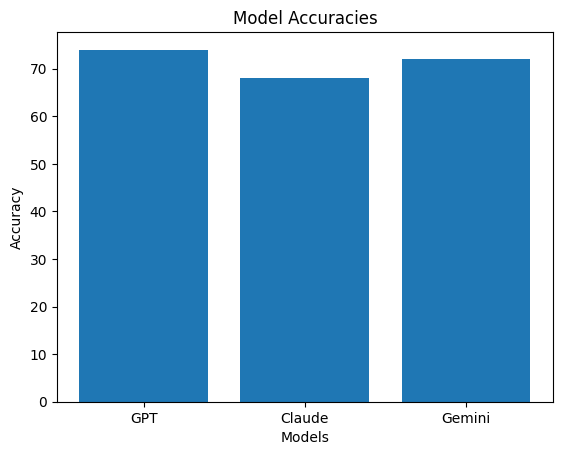

In [54]:
import matplotlib.pyplot as plt

models = ['GPT', 'Claude', 'Gemini']
scores = [openai_score*100, anthropic_score*100, google_score*100]

plt.bar(models, scores)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()

It appears that Claude has performed the best, with an accuracy of 74%.

Given that there are 124 countries in the dataset, this seems pretty impressive!

It should be noted that LLMs in general may struggle with countries like North Macedonia, which may not appear much in training data for LLMs